In [2]:
from mosqlient.models.baseline import Arima

Matplotlib is building the font cache; this may take a moment.


It calls the class associated with the Arima baseline model. In this step, it is necessary to define the city and disease to which the model will be applied.

In [3]:
m_arima = Arima(geocode = 3304557, disease = 'dengue')

m_arima

/Users/eduardoaraujo/Documents/Github/mosqlimate-client/mosqlient/models/baseline.py:169: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


### Train the model 

To use this method is necessary to define a data of begin and end of training

In [5]:
model = m_arima.train( train_ini_date='2010-01-01', train_end_date = '2021-12-31')

model

/Users/eduardoaraujo/Documents/Github/mosqlimate-client/mosqlient/models/baseline.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.y = boxcox.transform(df_train.y)[0]


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1623.743, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1795.167, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1660.025, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1636.206, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1793.175, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1623.296, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1633.190, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1634.070, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1624.196, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1633.250, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1634.835, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1627.277, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1621.317, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1631.229, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]          

ARIMA(maxiter=100, order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

#### Predictions in sample

Performace of the model in the sample

(626,)
(626, 2)


/opt/homebrew/Caskroom/miniforge/base/envs/mosqlient/lib/python3.10/site-packages/pmdarima/preprocessing/endog/boxcox.py:165: RuntimeWarning: invalid value encountered in power
  de_exp = numer ** (1. / lam1)  # de-exponentiate


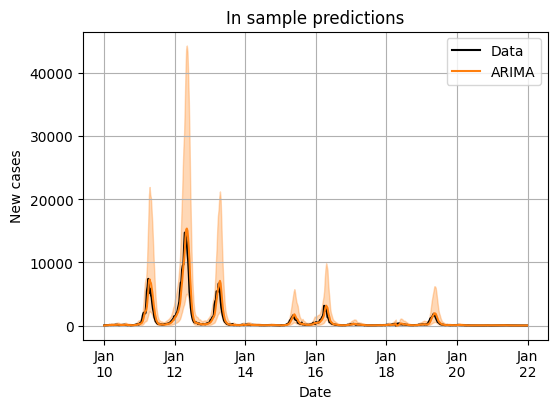

In [6]:
df_in_sample = m_arima.predict_in_sample(plot = True)

In [7]:
df_in_sample.head()

,date,preds,lower,upper,data
0,2010-01-03,0.999999,NaN,2.400394e+41,30.0
1,2010-01-10,29.999955,5.061386,1.546730e+02,44.0
2,2010-01-17,37.025185,7.759199,1.585018e+02,46.0
3,2010-01-24,41.279781,9.076377,1.695032e+02,47.0
4,2010-01-31,44.555058,9.899483,1.812958e+02,68.0


#### Predictions out of sample

In this method is necessary to define the end date for evaluation and the horizon that will be forecasted by the model

,date,preds,lower,upper,data
0,2022-01-02,5.675961,1.090617,26.186740,21.0
1,2022-01-09,5.082704,0.839703,26.676316,14.0
2,2022-01-16,4.643649,0.638469,28.441840,22.0
3,2022-01-23,4.312996,0.482247,31.340674,19.0
0,2022-01-30,17.464269,3.669479,74.594203,31.0


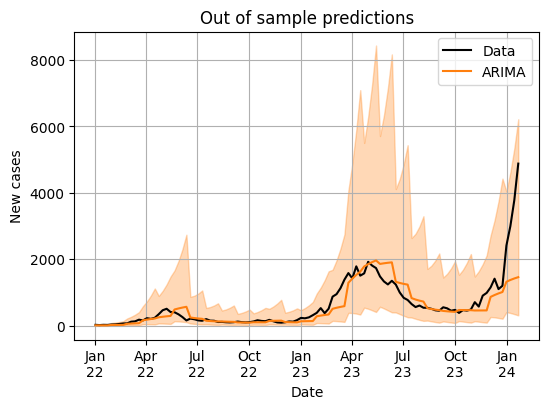

In [8]:
df_out = m_arima.predict_out_of_sample(horizon = 4, end_date = '2023-12-31', plot = True)

df_out.head()    

### Forecast 

To forecast is necessary to train the model before. The forecast will be done after the last day used in the training step. 

/Users/eduardoaraujo/Documents/Github/mosqlimate-client/mosqlient/models/baseline.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.y = boxcox.transform(df_train.y)[0]


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1800.501, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1986.356, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1838.788, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1820.321, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1984.410, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1800.874, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1817.466, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1795.478, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1818.133, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1796.222, Time=0.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1776.958, Time=0.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1804.844, Time=0.15 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1799.474, Time=0.36 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : 

,date,preds,lower,upper,adm_2
0,2024-01-07,1950.654449,668.615380,5369.847774,3304557
1,2024-01-14,2167.769160,679.666230,6460.488158,3304557
2,2024-01-21,2372.901769,671.350897,7742.348210,3304557
3,2024-01-28,2576.959678,654.688518,9236.041802,3304557


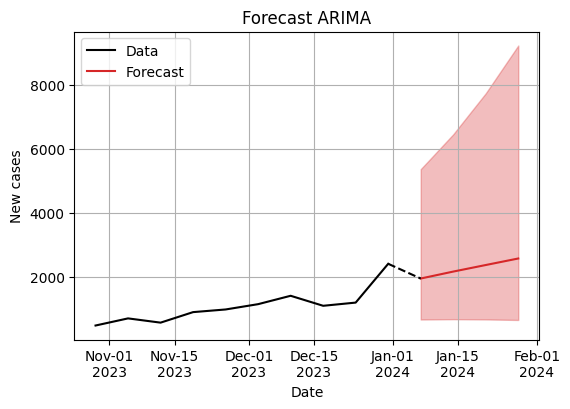

In [10]:
model = m_arima.train( train_ini_date='2010-01-01', train_end_date = '2023-12-31')

df_for = m_arima.forecast(horizon = 4, plot = True, last_obs = 10)

df_for.head()